In [ ]:
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import re

provinces = {
    "Hà Nội": (21.0285, 105.8542),
    "Đà Nẵng": (16.0544, 108.2022),
    "Nha Trang": (12.2388, 109.1967),
    "TP.HCM": (10.7769, 106.7009),
    "Cần Thơ": (10.0452, 105.7469),
    "Bình Thuận": (11.0904, 108.0721),
    "Ninh Thuận": (11.7557, 108.8463),
    "Huế": (16.4637, 107.5909),
    "Hải Phòng": (20.8449, 106.6881),
    "Điện Biên": (21.3860, 103.0181),
    "Quảng Ninh": (21.0064, 107.2925),
    "Đắk Lắk": (12.7100, 108.2378),
}

def get_solar_climate_data(lat, lon, start="2015", end="2024"):
    url = (
        f"https://power.larc.nasa.gov/api/temporal/monthly/point"
        f"?parameters=ALLSKY_SFC_SW_DWN,T2M,RH2M,WS2M,PRECTOT"
        f"&community=AG"
        f"&longitude={lon}"
        f"&latitude={lat}"
        f"&start={start}"
        f"&end={end}"
        f"&format=JSON"
    )

    response = requests.get(url)
    data = response.json()["properties"]["parameter"]

    params_available = data.keys()

    def get_param(param):
        return data[param] if param in data else {k: np.nan for k in data["T2M"].keys()}

    df = pd.DataFrame({
        "YearMonth": list(get_param("T2M").keys()),
        "GHI_kWh_m2_day": list(get_param("ALLSKY_SFC_SW_DWN").values()),
        "T2M": list(get_param("T2M").values()),
        "RH2M": list(get_param("RH2M").values()),
        "WS2M": list(get_param("WS2M").values()),
        "PRECTOT": list(get_param("PRECTOT").values())
    })

    def clean_yearmonth(val):
        match = re.match(r"(\d{4})(\d{1,2})", str(val))
        if match:
            year = match.group(1)
            month = match.group(2).zfill(2)
            return f"{year}{month}"
        return np.nan

    df["YearMonth"] = df["YearMonth"].apply(clean_yearmonth)
    df = df.dropna(subset=["YearMonth"])
    df["YearMonth"] = pd.to_datetime(df["YearMonth"], format="%Y%m", errors="coerce")

    df["Year"] = df["YearMonth"].dt.year
    df["Month"] = df["YearMonth"].dt.month
    df["Lat"] = lat
    df["Lon"] = lon

    return df


all_data = []
for name, (lat, lon) in tqdm(provinces.items(), desc="Collecting data from NASA"):
    try:
        df = get_solar_climate_data(lat, lon)
        df["Province"] = name
        all_data.append(df)
        time.sleep(2)
    except Exception as e:
        print(f"Error fetching data for {name}: {e}")

solar_df = pd.concat(all_data, ignore_index=True)

cols_to_float = ["GHI_kWh_m2_day", "T2M", "RH2M", "WS2M", "PRECTOT"]
solar_df[cols_to_float] = solar_df[cols_to_float].apply(pd.to_numeric, errors="coerce")
solar_df.fillna(solar_df.mean(numeric_only=True), inplace=True)

solar_df["GHI_Annual_kWh_m2_year"] = solar_df["GHI_kWh_m2_day"] * 365

annual_summary = (
    solar_df.groupby(["Province", "Year"])
    .agg({
        "GHI_kWh_m2_day": "mean",
        "GHI_Annual_kWh_m2_year": "mean",
        "T2M": "mean",
        "RH2M": "mean",
        "WS2M": "mean",
        "PRECTOT": "mean"
    })
    .reset_index()
)

solar_df.to_csv("solar_monthly_vietnam_full.csv", index=False, encoding="utf-8-sig")
annual_summary.to_csv("solar_annual_vietnam_full.csv", index=False, encoding="utf-8-sig")

print("Climate and energy data successfully collected!")
print("Files: solar_monthly_vietnam_full.csv and solar_annual_vietnam_full.csv")


In [ ]:
import pandas as pd
import plotly.express as px

df = pd.read_csv("solar_annual_vietnam_full.csv")

df = df.rename(columns={
    "Province": "Province",
    "GHI_kWh_m2_day": "Average Irradiance (kWh/m²/day)",
    "GHI_Annual_kWh_m2_year": "Annual Total Energy (kWh/m²/year)"
})

fig = px.histogram(
    df,
    x="Average Irradiance (kWh/m²/day)",
    color="Province",
    nbins=20,
    hover_data=["Year"],
    title="Distribution of Average Solar Irradiance Among Vietnam Provinces (2015-2024)"
)

fig.update_layout(
    xaxis_title="Average Solar Irradiance Level (kWh/m²/day)",
    yaxis_title="Number of Months in Period 2015-2024",
    legend_title_text="Province",
    template="plotly_white",
    title_x=0.5,
)

fig.add_annotation(
    text=(
        "Note:\n"
        "- X-axis: Average daily solar energy level (kWh/m²/day).\n"
    ),
    xref="paper", yref="paper",
    x=0, y=-0.25, showarrow=False,
    font=dict(size=12),
    align="left"
)

fig.show()


In [ ]:
import pandas as pd
import plotly.express as px

df = pd.read_csv("solar_annual_vietnam_full.csv")

df = df[df["Year"] >= 2015]
df["Year"] = df["Year"].astype(int)

fig = px.line(
    df,
    x="Year",
    y="GHI_kWh_m2_day",
    color="Province",
    markers=True,
    hover_data={"Year": True, "GHI_kWh_m2_day": ':.2f', "Province": True},
    title="☀️ Average Solar Irradiance (GHI) Trend Over Time 2015-2024",
)

fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Average Irradiance (kWh/m²/day)",
    legend_title="Province",
    template="plotly_white",
    hovermode="x unified",
    height=600,
    title_x=0.5,
    font=dict(size=13)
)

fig.show()


In [ ]:
import pandas as pd
import plotly.express as px

df = pd.read_csv("solar_monthly_vietnam_full.csv")

geo_summary = (
    df.groupby(["Province", "Lat", "Lon"])
    .agg({"GHI_kWh_m2_day": "mean"})
    .reset_index()
)

fig = px.scatter(
    geo_summary,
    x="Lat",
    y="GHI_kWh_m2_day",
    text="Province",
    color="GHI_kWh_m2_day",
    color_continuous_scale="YlOrRd",
    hover_data={"Province": True, "Lat": ':.2f', "Lon": ':.2f', "GHI_kWh_m2_day": ':.2f'},
    title="Relationship Between Latitude and Average Solar Irradiance in Vietnam",
    trendline="ols"
)

fig.update_traces(textposition="top center")
fig.update_layout(
    xaxis_title="Latitude",
    yaxis_title="Average Irradiance (kWh/m²/day)",
    coloraxis_colorbar_title="Irradiance (kWh/m²/day)",
    template="plotly_white"
)

fig.show()


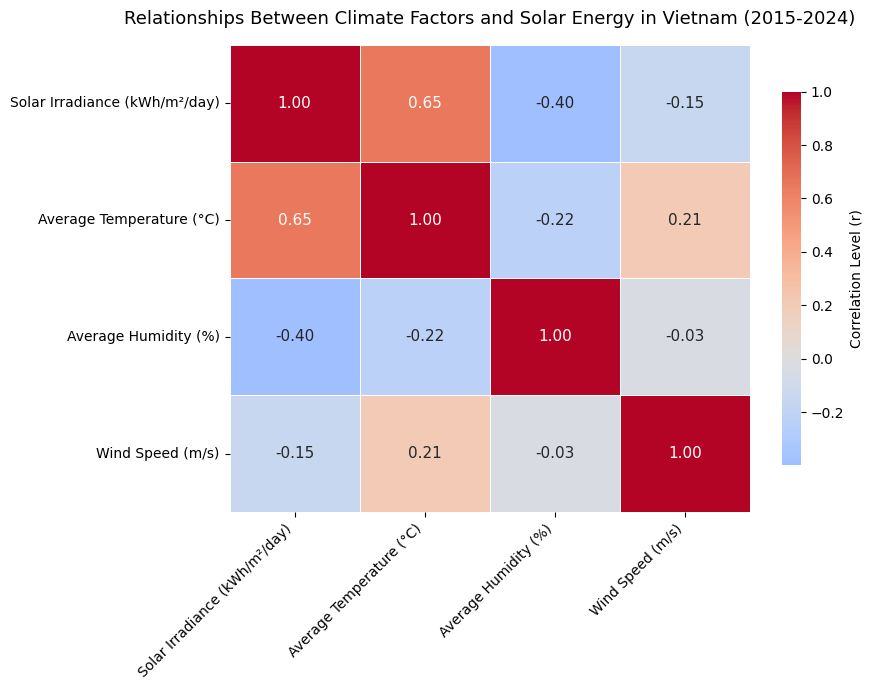

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("solar_monthly_vietnam_full.csv")

df_en = df.rename(columns={
    "GHI_kWh_m2_day": "Solar Irradiance (kWh/m²/day)",
    "T2M": "Average Temperature (°C)",
    "RH2M": "Average Humidity (%)",
    "WS2M": "Wind Speed (m/s)",
    
})

cols = [
    "Solar Irradiance (kWh/m²/day)",
    "Average Temperature (°C)",
    "Average Humidity (%)",
    "Wind Speed (m/s)",
   
]

corr = df_en[cols].corr(method="pearson")

plt.figure(figsize=(9, 7))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Correlation Level (r)"},
    annot_kws={"size": 11}
)

plt.title(
    "Relationships Between Climate Factors and Solar Energy in Vietnam (2015-2024)",
    fontsize=13, pad=15
)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import plotly.express as px

df = pd.read_csv("solar_monthly_vietnam_full.csv")

df = df.dropna(subset=["Lat", "Lon", "GHI_kWh_m2_day"])

fig = px.scatter_mapbox(
    df,
    lat="Lat",
    lon="Lon",
    color="GHI_kWh_m2_day",
    size="GHI_kWh_m2_day",
    hover_name="Province",
    color_continuous_scale=px.colors.sequential.YlOrRd,
    size_max=20,
    zoom=4.5,
    width=1000,
    height=700,
    mapbox_style="open-street-map",
    title="Solar Energy Potential Distribution in Vietnam",
    hover_data={
        "Lat": ':.2f',
        "Lon": ':.2f',
        "GHI_kWh_m2_day": ':.2f'
    }
)

fig.update_layout(
    title_font=dict(size=20, family="Arial", color="#333"),
    title_x=0.5,
    paper_bgcolor="white",
    margin=dict(l=0, r=0, t=60, b=0),
    coloraxis_colorbar=dict(
        title="Irradiance (kWh/m²/day)",
        tickvals=[4, 4.5, 5, 5.5, 6],
        ticks="outside"
    ),
)

fig.show(config={
    'scrollZoom': True,
    'displaylogo': False,
    'modeBarButtonsToRemove': ['lasso2d', 'select2d'],
    'displayModeBar': True
})


C:\Users\APC\AppData\Local\Temp\ipykernel_10852\1487996820.py:11: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



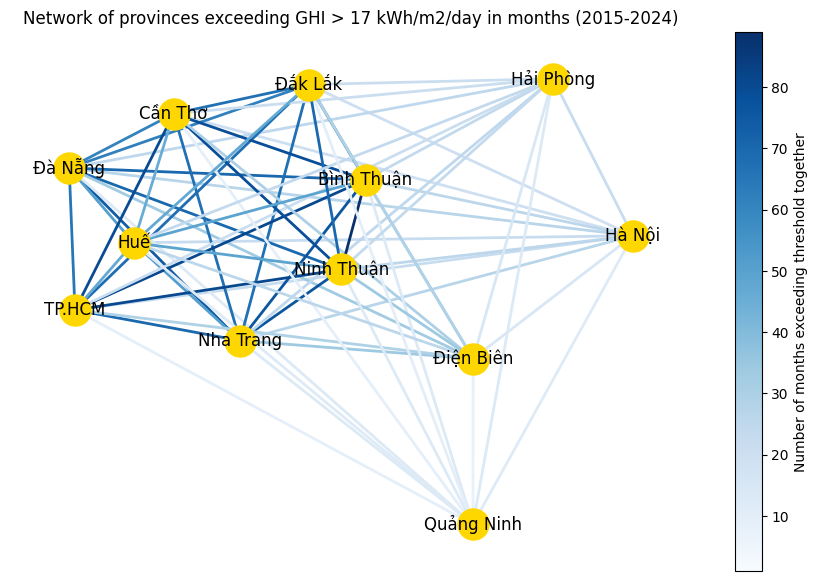

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

monthly = pd.read_csv('solar_monthly_vietnam_full.csv')

THRESHOLD = 17
months = monthly['YearMonth'].unique()
G = nx.Graph()

provinces = list(monthly['Province'].unique())
for p in provinces:
    G.add_node(p)

for m in months:
    m_data = monthly[(monthly['YearMonth'] == m) & (monthly['GHI_kWh_m2_day'] > THRESHOLD)]
    selected_prov = m_data['Province'].tolist()
    for u, v in combinations(selected_prov, 2):
        if G.has_edge(u, v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)

plt.figure(figsize=(11, 7))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='gold', node_size=500)
nx.draw_networkx_labels(G, pos)

edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
max_weight = max(weights) if weights else 1

edge_collection = nx.draw_networkx_edges(
    G, pos,
    edge_color=weights,
    edge_cmap=plt.cm.Blues,
    width=2,
    edge_vmin=1, edge_vmax=max_weight
)

if edge_collection is not None:
    plt.colorbar(edge_collection, label='Number of months exceeding threshold together')

plt.title(f'Network of provinces exceeding GHI > {THRESHOLD} kWh/m2/day in months (2015-2024)')
plt.axis('off')
plt.show()